In [2]:
import pandas as pd
import seaborn as sns

In [3]:
# Create a DataFrame of the mean value of the runs for each kernel, for each model, for one architecture
def average(arch):
    return data.loc[data['arch'] == arch].groupby(['kernel','model'], as_index=False).mean()

# Create a DataFrame of the minimum value of the runs for each kernel, for each model, for one architecture
def lower(arch):
    return data.loc[data['arch'] == arch].groupby(['kernel','model'], as_index=False).min()

# Create a DataFrame of the maximum value of the runs for each kernel, for each model, for one architecture
def upper(arch):
    return data.loc[data['arch'] == arch].groupby(['kernel','model'], as_index=False).max()


# Create a DataFrame of the mean value of the runs for each kernel for one architecture/compiler combination
def average_c(arch, compiler):
    return data.loc[(data['arch'] == arch) & (data['compiler'] == compiler)].groupby(['kernel','model'], as_index=False).mean()

# Plot a grouped bar chart of mean value of each kernel in each model for a given architecture
def plot(arch):
    chart = sns.catplot(x='kernel', y='bandwidth', hue='model', data=average(arch), kind='bar', ci=None)
    chart.set_xticklabels(rotation=45, horizontalalignment="right")
    chart.savefig('{0}.png'.format(arch))

# Plot a grouped bar chart of mean value of each kernel in each model for a given architecture/compiler combination
def plot_c(arch, compiler):
    chart = sns.catplot(x='kernel', y='bandwidth', hue='model', data=average_c(arch, compiler), kind='bar', ci=None)
    chart.set_xticklabels(rotation=45, horizontalalignment="right")
    chart.savefig('{0}_{1}.png'.format(arch,compiler))

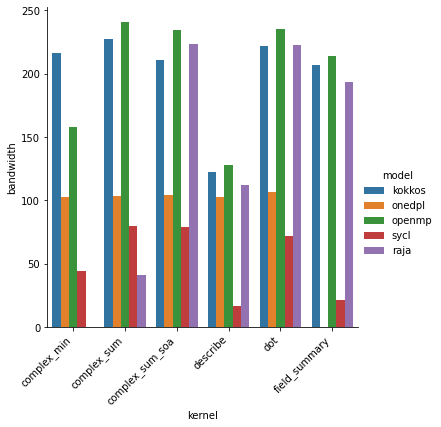

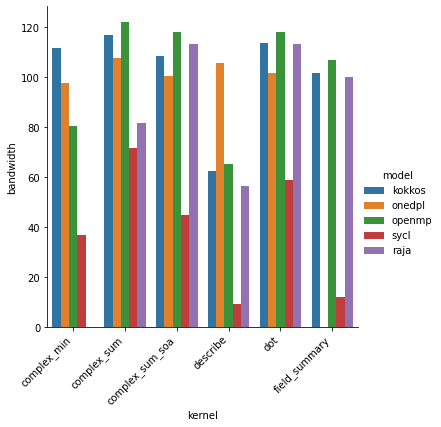

In [7]:
data = pd.read_csv("./clx-results.csv", skipinitialspace=True)
plot('clx')
data = pd.read_csv("./clx-1S-results.csv", skipinitialspace=True)
plot('clx_1S')

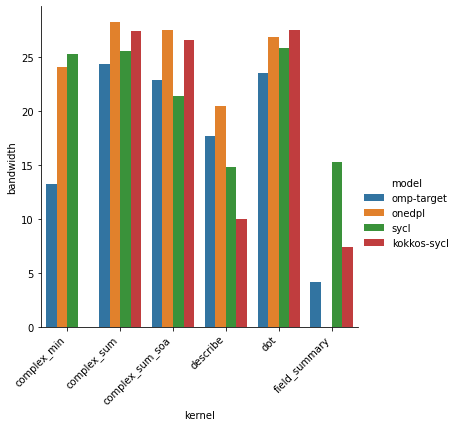

In [5]:
data = pd.read_csv("./gen9-results.csv", skipinitialspace=True)
plot('gen9')

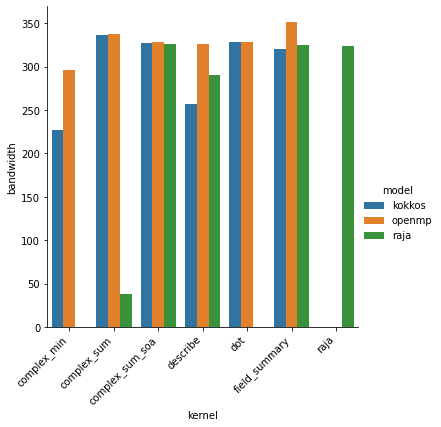

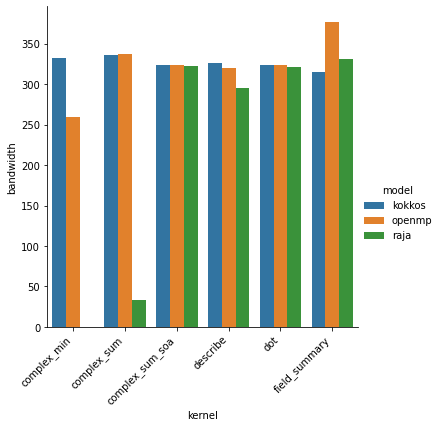

In [6]:
data = pd.read_csv("./rome-results-cce.csv", skipinitialspace=True)
plot_c('rome', 'cce')
data = pd.read_csv("./rome-results-aocc.csv", skipinitialspace=True)
plot_c('rome', 'aocc')